## Kaggle Digit Recognizer

This tutorial will demonstrate how to use Convolutional Neural Networks (CNNs) to identify hand-written digits (0-9) from the MNIST dataset. This should provide a simple introduction to Image Classification that will be useful for any Kaggle beginners. In this notebook I will be using the MNIST dataset from Kaggle, not from keras.datasets.

There are 4 simple steps for CNN:

1. Loading and preprocessing (rescaling) images

2. Split into train/validation/test set 

3. Design CNN model

4. Training model (+Img augmentation) for specified num. of epochs/batch size

In [1]:
## Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

/Users/ryan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 1. Loading and preprocessing (rescaling) images

In [2]:
## load train dataset 
## (We will load test.csv later to submit predictions using the final model)
train = pd.read_csv('../input/train.csv')

In [3]:
## labels : target variables -> 0 - 9 
## num_classes : number of unique labels -> 10
## y_train : Converts a class vector (integers) to binary class matrix
labels = train.label
num_classes = len(np.unique(labels))
y_train = np_utils.to_categorical(labels, num_classes)

Next step is to reshape the training dataset into tensor into (n_row, 28, 28, 1). Note that this dataset was originally stored as 784-element vectors, 
for each sample, not 28 x 28 matrices. We reshape each sample into
this tensor format, including 28 x 28 and number of channels.
Here, number of channels is 1 because this is not RGB color image.

In [4]:
## Drop labels from training set
train_features = train.drop('label',axis=1)
train_tensors = train_features.values.reshape(
                    train_features.shape[0],28,28,1).astype('float32')/255

Done! Easy! huh?


## 2. Split into train/validation/test dataset

StratifiedSplit helps retain the same proportion of the classes in both splits.

In [5]:
## (2) split x,y -> train (80%), validation (80%), test (80%)
strati = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in strati.split(train_tensors, y_train):
    train_tensors, valid_tensors = train_tensors[train_index], train_tensors[test_index]
    y_train, y_valid = y_train[train_index], y_train[test_index]

strati = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42) 
for train_index, test_index in strati.split(valid_tensors, y_valid):
    valid_tensors, test_tensors = valid_tensors[train_index], valid_tensors[test_index]
    y_valid, y_test = y_valid[train_index], y_valid[test_index]

## 3. Design CNN Architecture

I designed my own CNN Architecture, using Convolution, Pooling and dropout layers. You can change any specific parameters and layers if you want.

In [6]:
## Design Model===================================================
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=2, activation='relu',
               input_shape=train_tensors.shape[1:]))
model.add(Conv2D(filters=32,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64,kernel_size=2, activation='relu'))
model.add(Conv2D(filters=64,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128,kernel_size=2, activation='relu'))
model.add(Conv2D(filters=128,kernel_size=2, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(1024,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(10,activation='softmax'))
#=================================================================

## 4.  Training model

In [7]:
## Compile model with a optimizer (RMS) and accuracy as the metric
model.compile(optimizer=RMSprop(lr=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## We'll use EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau.
checkpointer = [EarlyStopping(monitor='val_loss', patience=5, verbose=0), 
                ModelCheckpoint(filepath='weights.hdf5', 
                            monitor='val_loss', save_best_only=True, 
                            verbose=0),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                              patience=2, verbose=0, 
                              mode='auto',  cooldown=0, min_lr=0)]

## We'll use Image Augmentation
datagen =ImageDataGenerator(rotation_range=8, 
                            width_shift_range=0.1, 
                            shear_range=0.3,
                            height_shift_range=0.1, 
                            zoom_range=0.1)

## Train the model with epochs=20, batch_size=64
batch_size=64
epochs=20
final = model.fit_generator(datagen.flow(train_tensors, y_train, batch_size=batch_size),
            steps_per_epoch=len(train_tensors)/batch_size, 
            validation_data=datagen.flow(valid_tensors, y_valid, batch_size=batch_size), 
            validation_steps=len(valid_tensors)/batch_size,
            callbacks=checkpointer,
            epochs=epochs, 
            verbose=1)

Epoch 1/20
525/525 [==============================] - 95s 181ms/step - loss: 0.6357 - acc: 0.7877 - val_loss: 0.3685 - val_acc: 0.8900
Epoch 2/20
525/525 [==============================] - 88s 168ms/step - loss: 0.2255 - acc: 0.9332 - val_loss: 0.1266 - val_acc: 0.9619
Epoch 3/20
525/525 [==============================] - 88s 168ms/step - loss: 0.1643 - acc: 0.9520 - val_loss: 0.1492 - val_acc: 0.9588
Epoch 4/20
525/525 [==============================] - 87s 167ms/step - loss: 0.1431 - acc: 0.9588 - val_loss: 0.1502 - val_acc: 0.9557
Epoch 5/20
525/525 [==============================] - 88s 167ms/step - loss: 0.0866 - acc: 0.9742 - val_loss: 0.0725 - val_acc: 0.9783
Epoch 6/20
525/525 [==============================] - 88s 168ms/step - loss: 0.0773 - acc: 0.9772 - val_loss: 0.0663 - val_acc: 0.9788
Epoch 7/20
525/525 [==============================] - 87s 166ms/step - loss: 0.0740 - acc: 0.9788 - val_loss: 0.0744 - val_acc: 0.9783
Epoch 8/20
525/525 [==============================] - 8

In [8]:
def plot_lc(model_history):
    n = len(model_history.history['acc'])
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)

    ax1.plot(range(1,n+1),model_history.history['acc'])
    ax1.plot(range(1,n+1),model_history.history['val_acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    ax1.set_xticks(np.arange(1,n+1),n/10)
    ax1.legend(['train', 'val'], loc='best')

    ax2 = fig.add_subplot(122)
    ax2.plot(range(1,n+1),model_history.history['loss'])
    ax2.plot(range(1,n+1),model_history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    ax2.set_xticks(np.arange(1,n+1),n/10)
    ax2.legend(['train', 'val'], loc='best')
    plt.show()

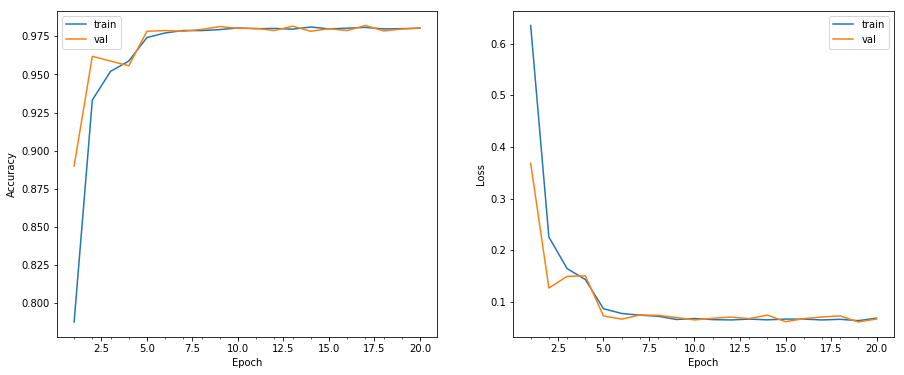

In [9]:
plot_lc(final)

In [10]:
result = model.predict(test_tensors)
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0)))
             for feature in test_tensors]
true_class = np.argmax(y_test, axis=1)
num_correct = np.sum(predictions == true_class) 
accuracy = float(num_correct)/result.shape[0]
print(accuracy)

0.9883333333333333


In [11]:
def plot_confusion(pltname,predictions,test_list):
    ## Check a confusion matrix with the result using test dataset.
    confusion = confusion_matrix(test_list,predictions)
    ## Plot Confusion Matrix
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax = sns.heatmap(confusion, ax=ax, cmap=plt.cm.Oranges, annot=True,fmt='3d')
#    ax.set_xticklabels(range(10))
#    ax.set_yticklabels(range(10))
    plt.title('Confusion Matrix',size=20)
    plt.ylabel('True',size=16)
    plt.xlabel('Predicted',size=16)
    plt.savefig(pltname,dpi=150)

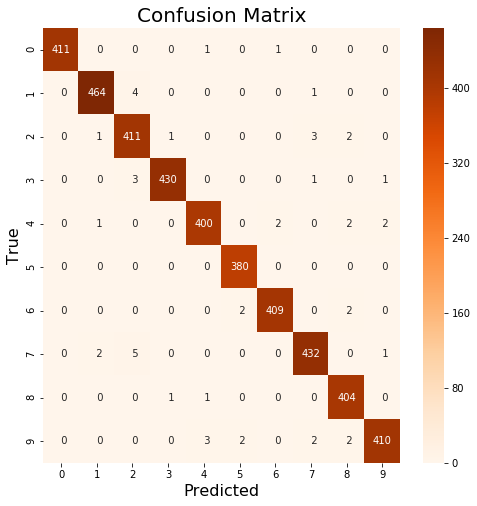

In [12]:
plot_confusion('confusion.png',predictions,true_class)

## 5. Retrain the model with train/validation set

In [13]:
strati = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) 
for train_index, test_index in strati.split(train_tensors, y_train):
    train_tensors, valid_tensors = train_tensors[train_index], train_tensors[test_index]
    y_train, y_valid = y_train[train_index], y_train[test_index]


final = model.fit_generator(datagen.flow(train_tensors, y_train, batch_size=batch_size),
            steps_per_epoch=len(train_tensors)/batch_size, 
            validation_data=datagen.flow(valid_tensors, y_valid, batch_size=batch_size), 
            validation_steps=len(valid_tensors)/batch_size,
            callbacks=checkpointer,
            epochs=epochs, 
            verbose=1)

Epoch 1/20
473/472 [==============================] - 78s 164ms/step - loss: 0.0670 - acc: 0.9809 - val_loss: 0.0572 - val_acc: 0.9824
Epoch 2/20
473/472 [==============================] - 77s 163ms/step - loss: 0.0636 - acc: 0.9810 - val_loss: 0.0651 - val_acc: 0.9830
Epoch 3/20
473/472 [==============================] - 77s 163ms/step - loss: 0.0655 - acc: 0.9810 - val_loss: 0.0613 - val_acc: 0.9815
Epoch 4/20
473/472 [==============================] - 78s 164ms/step - loss: 0.0705 - acc: 0.9791 - val_loss: 0.0702 - val_acc: 0.9786
Epoch 5/20
473/472 [==============================] - 79s 167ms/step - loss: 0.0664 - acc: 0.9803 - val_loss: 0.0633 - val_acc: 0.9815
Epoch 6/20
473/472 [==============================] - 77s 163ms/step - loss: 0.0668 - acc: 0.9803 - val_loss: 0.0611 - val_acc: 0.9810


In [14]:
test = pd.read_csv('../input/test.csv')
test_tensors = test.values.reshape(
                    test.shape[0],28,28,1).astype('float32')/255

result = model.predict(test_tensors)
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0)))
             for feature in test_tensors]

In [29]:
submission = pd.DataFrame({ 'ImageId': test.index.values+1,
                            'Label': predictions })

In [30]:
submission.to_csv("submission.csv",index=False)

In [31]:
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


array([    1,     2,     3, ..., 27998, 27999, 28000])

In [22]:
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
